### Notebook for dynamic concept presence analysis

In [1]:
%load_ext autoreload
%autoreload 2

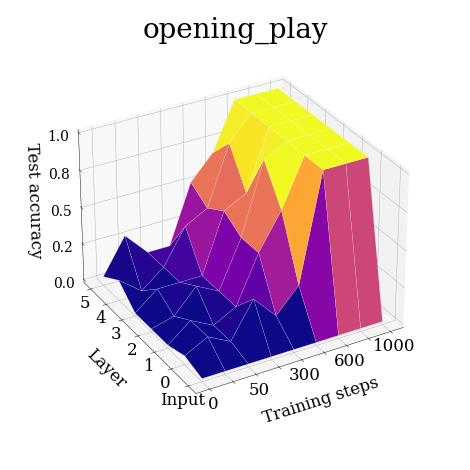

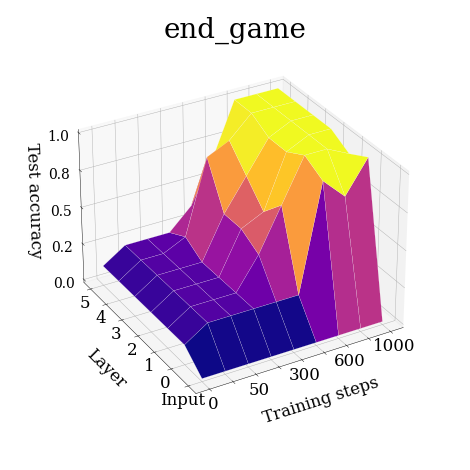

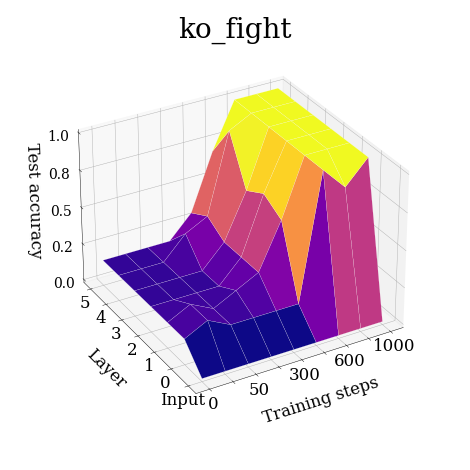

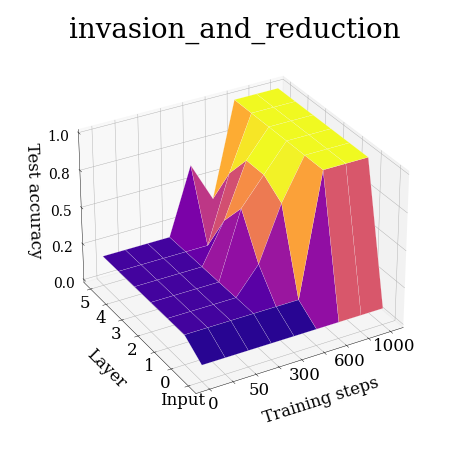

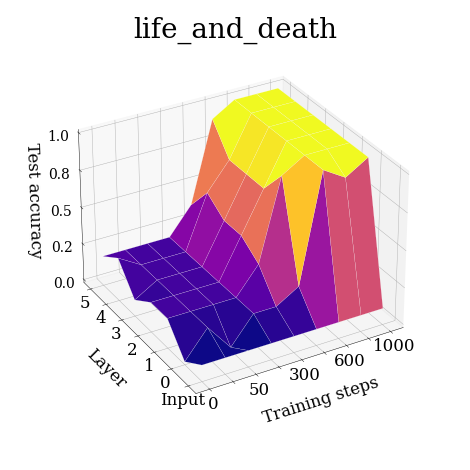

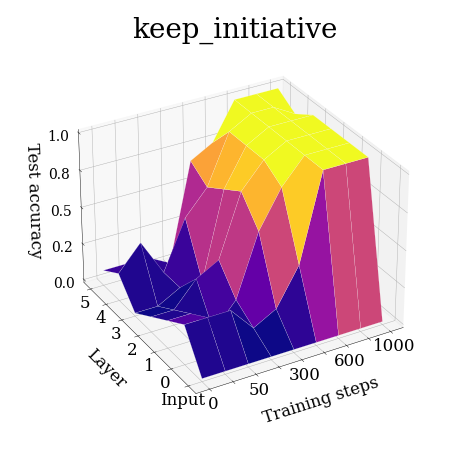

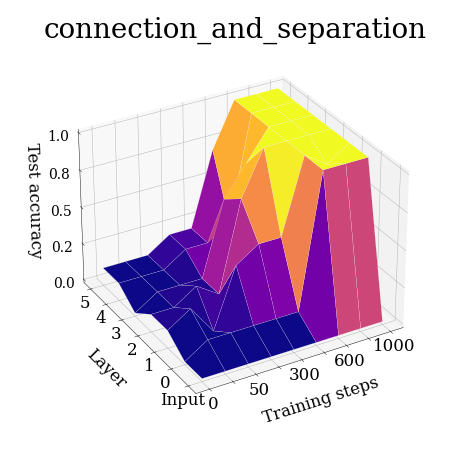

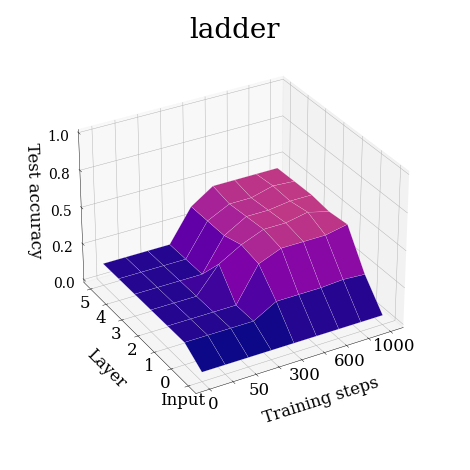

In [33]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import json

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

session_name = 'probing'
board_name = '7x7'

levels = [0, 10, 50, 100, 300, 500, 600, 800, 1000]

resnet = True

model_type = "resnet" if resnet else "convnet"

dynamic_concepts = ['opening_play', 'end_game', 'ko_fight', 'invasion_and_reduction', 'life_and_death', 'keep_initiative', 'connection_and_separation', 'ladder']

for concept in dynamic_concepts:
    if not os.path.exists(f"../concept_presences/dynamic/{model_type}/{board_name}/{session_name}/{concept}"):
        print(f"Skipping {concept} as it does not exist")
        continue

    z = []

    for level in levels:
        presences = []
        for file in os.listdir(f"../concept_presences/dynamic/{model_type}/{board_name}/{session_name}/{concept}/{level}"):
            with open(os.path.join(f"../concept_presences/dynamic/{model_type}/{board_name}/{session_name}/{concept}/{level}", file)) as f:
                data = json.load(f)
                presences.append(data)

        y = []

        for (i, presence) in enumerate(presences):
            y = []
            for j, ind_presence in enumerate(presence):
                y.append(ind_presence)
            z.append(y)
    
    # Input regression plot
    input_presences = None
    # Test if input presence file exists
    if os.path.exists(f"../concept_presences/dynamic/{model_type}/{board_name}/{session_name}/{concept}/input"):
        for file in os.listdir(f"../concept_presences/dynamic/{model_type}/{board_name}/{session_name}/{concept}/input"):
            with open(os.path.join(f"../concept_presences/dynamic/{model_type}/{board_name}/{session_name}/{concept}/input", file)) as f:
                data = json.load(f)
                input_presences = data

    # Add the input presence to each subarray in z
    if input_presences is not None:
        z = [[input_presences] + subarray for subarray in z]

    # Remove the last two items in each subarray (due to the last two have few filters resulting in low regression score)
    if len(levels) == 9:
        # Remove the two last items in each subarray
        z = [subarray[:-2] for subarray in z]
    z = np.array(z)

    mpl.style.use("seaborn-v0_8-muted")
    mpl.rcParams['figure.figsize'] = (15, 15)
    mpl.rcParams['lines.linewidth'] = 10.0

    mpl.rcParams['font.family'] = "serif"
    mpl.rcParams["axes.axisbelow"] = True
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Scale down the figure size with setting the resolutionof the figure in dots-per-inch
    fig.set_dpi(40)

    # Make data.
    X = np.arange(len(levels))
    Y = np.arange(z.shape[1])
    X, Y = np.meshgrid(Y, X)

    # Plot the surface.
    surf_2 = ax.plot_surface(X, Y, z, cmap=cm.plasma, edgecolor="white",
                             linewidth=0.25, vmin=0.1, vmax=0.9, alpha=1)

    # Customize the z axis.
    ax.set_zlim(0, 1.0)
    ax.set_axisbelow(False)
    ax.set_title(concept, fontsize=50, y=1)
    ax.set_xlabel("Layer", fontsize=30, labelpad=45, zorder=10)
    ax.set_ylabel("Training steps", fontsize=30, labelpad=45, zorder=10)
    ax.set_zlabel("Test accuracy", fontsize=30, labelpad=45, zorder=10)
    ax.set_box_aspect(aspect=None, zoom=0.8)
    plt.xticks(fontsize=30, rotation=0)
    plt.xticks(np.arange(z.shape[1]))
    plt.yticks(fontsize=30)
    ax.tick_params('z', labelsize=25, pad=20, reset=True)
    fig.patch.set_facecolor("white")

    ax.invert_xaxis()

    # Set custom x-axis labels
    x_labels = ['Input'] + list(range(0, z.shape[1] - 1))
    ax.set_xticklabels(x_labels)
    #ax.tick_params(axis='x', rotation=30)

    # Move the z-axis to the other side
    ax.zaxis._axinfo['juggled'] = (1, 2, 0)

    ax.zaxis.set_major_locator(LinearLocator(5))

    labels = levels.copy()
    labels[0] = 0
    plt.yticks(np.arange(len(levels)), labels)
    yticks = ax.yaxis.get_major_ticks()
    for i in range(1, len(labels), 2):
        yticks[i].label1.set_visible(False)

    yticks[-1].label1.set_visible(True)
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.01f}')
    ax.view_init(30, -30)
    

    os.makedirs(f"plots/dynamic/{model_type}/{board_name}/{session_name}", exist_ok=True)
    plt.savefig(f"plots/dynamic/{model_type}/{board_name}/{session_name}/{concept}.png", transparent=False)